In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
import numpy as np

In [2]:
import numpy as np

class MyPCA:
    """
    A small class to perform PCA
    ------------
    Attributes:
    n_components: int, default is None
        number of principal components we want to project on
    eigvecs_: None
        All eigenvectors of covariance matrix decomposition, sorted w.r.t the maximum eigenvalues
    eigvals_: None
        All eigenvalues of covariance matrix decomposition, sorted w.r.t the maximum eigenvalues
    singular_values_: None
        The singular values corresponding to each of the selected components. The singular values are equal to the 2-norms of the n_components variables in the lower-dimensional space
    top_eigvecs: None
        The projection matrix
    """
    
    def __init__(self, n_components=None):
        """
        Constructor for PCA class.
        ----------
        Parameters:
        n_components : int (optional)
            The number of principal components we want to project on (default is None, meaning to project on all components).
        """
        self.n_components = n_components
        self.eigvecs_ = None
        self.eigvals_ = None
        self.singular_values_ = None
        self.top_eigvecs = None
    
    def fit_transform(self, X):
        """
        Fit the PCA model to data and transform the data.
        ----------
        Parameters:
        X : numpy array
            The data to fit the PCA model and transform, required in the form: (n x p) where n = number of observations and p = number of features
        ----------
        Returns:
        projected_data : numpy array
            The projected data.
        """
        # center the data in the feature space
        X_centered = X - np.mean(X, axis=0)

        # compute the covariance matrix
        cov_matrix = np.dot(X_centered.T, X_centered)/(X.shape[0])

        # perform eigen decomposition on the covariance matrix
        eigvals, eigvecs = np.linalg.eig(cov_matrix)

        # sort eigenvectors in decreasing order of eigenvalues
        idx = np.argsort(eigvals)[::-1]        
        eigvecs = eigvecs[:, idx]
        eigvals = eigvals[idx]
        
        self.eigvecs_ = eigvecs
        self.eigvals_ = eigvals

        self.singular_values_ = np.linalg.norm(np.dot(X, self.eigvecs_), axis = 0)

        self.top_eigvecs = self.eigvecs_

        # select the top n_components eigenvectors
        if self.n_components is not None:
            self.top_eigvecs = self.eigvecs_[:, :self.n_components]

        # project the original data onto the selected eigenvectors
        projected_data = np.dot(X, self.top_eigvecs)

        return projected_data

## Exercise 1

In [3]:
X = np.genfromtxt("../Datasets/data_kPCA_2022-2023.txt")
y = np.genfromtxt("../Datasets/labels_kPCA_2022-2023.txt")

### Linear PCA

Apply `MyPCA` and `sklearn.decomposition.PCA` to the dataset.

In [4]:
mypca = MyPCA(2)
skpca = PCA(2)
X_projected = mypca.fit_transform(X)
X_projected_ = skpca.fit_transform(X)

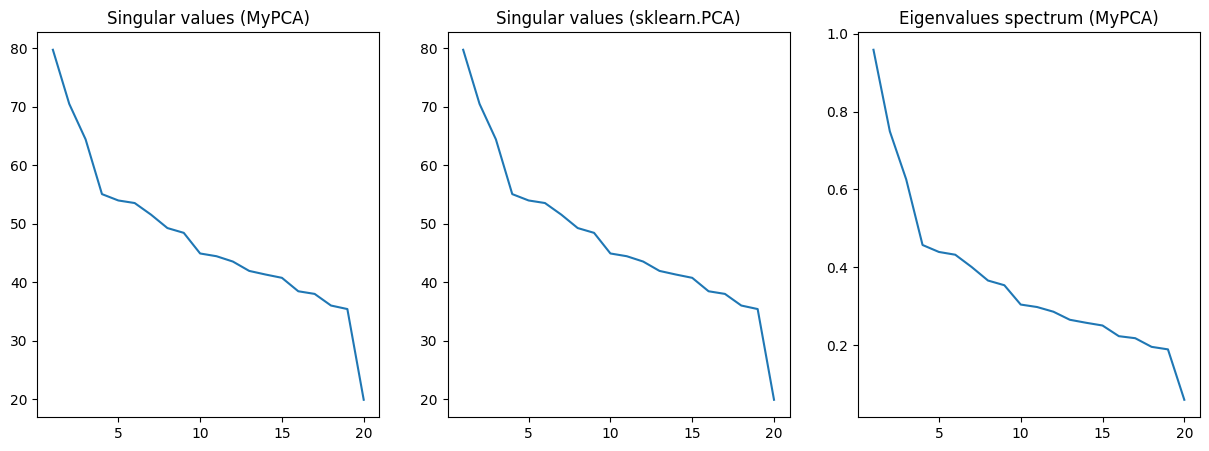

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

ax1.plot(np.arange(1, X.shape[1] + 1) ,mypca.singular_values_)
ax1.set_title('Singular values (MyPCA)')

ax2.plot(np.arange(1, X.shape[1] + 1) ,PCA().fit(X).singular_values_ )
ax2.set_title('Singular values (sklearn.PCA)')

ax3.plot(np.arange(1, X.shape[1] + 1), mypca.eigvals_)
ax3.set_title('Eigenvalues spectrum (MyPCA)')

plt.show()


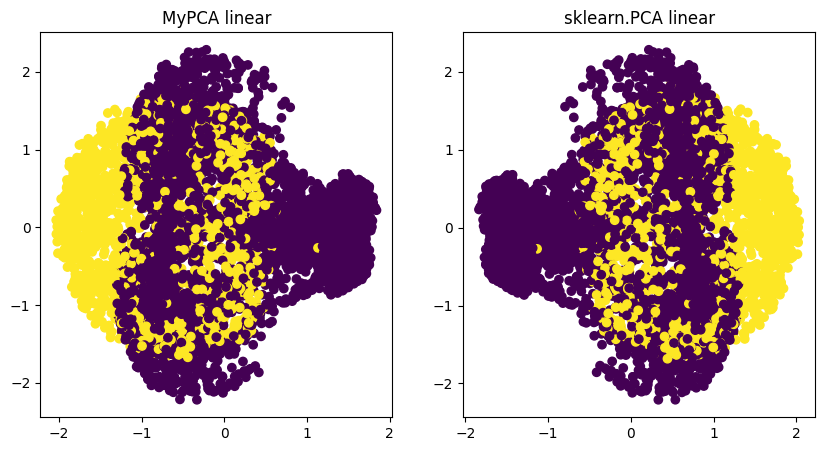

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.scatter(X_projected[:,0], X_projected[:,1], c = y)
ax1.set_title('MyPCA linear')

ax2.scatter(X_projected_[:,0], X_projected_[:,1], c = y)
ax2.set_title('sklearn.PCA linear')

plt.show()


## Kernel PCA

### Gaussian kernel

In [7]:
class MyRBFKernelPCA:
    """
    A small class to perform gaussian kernl PCA
    ------------
    Attributes:
    n_components: int, default is None
        number of principal components we want to project on
    gamma: float
        kernel coefficient (gaussian)
    top_k_eigvals_: None
        projection matrix
    """
    
    def __init__(self, n_components=None, gamma = 1.0):
        """
        Constructor for MyRBFKernelPCA.
        ----------
        Parameters:
        n_components : int (optional)
            The number of principal components we want to project on (default is None, meaning to project on all components).
        gamma: float
            kernel coefficient (gaussian)
        """
        self.n_components = n_components
        self.gamma = gamma
    
    def fit_transform(self, X):
        """
        Fit the kernel PCA model.
        ----------
        Parameters:
        X : numpy array
            The data to fit the PCA model and transform, required in the form: (n x p) where n = number of observations and p = number of features
        ----------
        Returns:
        projected_data : numpy array
            The projected data.
        """
        # compute the squared Euclidean distances
        D = np.sum(X**2, axis=1).reshape(-1, 1) + np.sum(X**2, axis=1) - 2*np.dot(X, X.T)
        
        # compute the RBF kernel matrix
        K = np.exp(-self.gamma*D)

        # double center the kernel matrix
        n = K.shape[0]
        one_n = np.ones((n, n)) / n
        K_centered = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
        

        eig_vals, eig_vecs = np.linalg.eig(K_centered)
        eig_vals = np.where(eig_vals<0,0, eig_vals)
        sorted_indices = np.argsort(eig_vals)[::-1]
        sorted_eigvecs = eig_vecs[:,sorted_indices]
        sorted_eigvals = eig_vals[sorted_indices]

        # select the first k eigenvector(s) and project
        top_k_eigvecs = sorted_eigvecs[:,:self.n_components]
        top_k_eigvals = sorted_eigvals[:self.n_components]

        # projected_data = np.dot(K_centered, self.top_k_eigvecs) sbagliato, capire perche 

        return np.dot(top_k_eigvecs, np.sqrt(np.diag(top_k_eigvals)))

In [ ]:
# a function to do kernel PCA (not a class)
import numpy as np

def my_rbfPCA(X, k, gamma):
    """
    X: numpy array
        array with n observation and p features (nxp)
    k: int
        number of principal components we want to project on
    sigma: float
        width parameter of the RBF kernel
    output: numpy array
        return the projected data (nxk), where k is the number of principal components we have projected on
    """
    # center the data in the feature space
    X_centered = X - np.mean(X, axis=0)

    # compute the squared Euclidean distances
    D = np.sum(X_centered**2, axis=1).reshape(-1, 1) + np.sum(X_centered**2, axis=1) - 2*np.dot(X_centered, X_centered.T)
    
    # compute the RBF kernel matrix
    K = np.exp(-gamma*D)
    
    # double center the kernel matrix
    n = K.shape[0]
    one_n = np.ones((n, n)) / n
    K_centered = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
    
    # perform eigen decomposition on the centered kernel matrix
    _, eigvecs = np.linalg.eigh(K_centered)
    
    # select the top k eigenvectors and project the original data
    top_k_eigvecs = eigvecs[:, -k:]
    projected_data = np.dot(K_centered, top_k_eigvecs)

    return projected_data


In [8]:
gamma = 2.0
X_projected_ = KernelPCA(n_components=3, kernel='rbf', gamma=gamma).fit_transform(X[:1000,:])
X_projected = MyRBFKernelPCA(3, gamma = gamma).fit_transform(X[:1000,:])

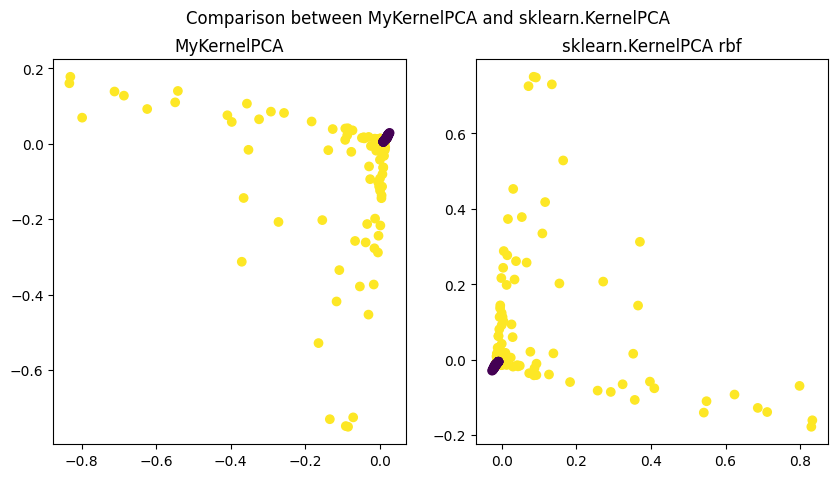

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

fig.suptitle('Comparison between MyKernelPCA and sklearn.KernelPCA')

ax1.scatter(X_projected[:,0], X_projected[:,1], c = y.ravel()[:1000])
ax1.set_title('MyKernelPCA')

ax2.scatter(X_projected_[:,0], X_projected_[:,1], c = y.ravel()[:1000])
ax2.set_title('sklearn.KernelPCA rbf')

plt.show()

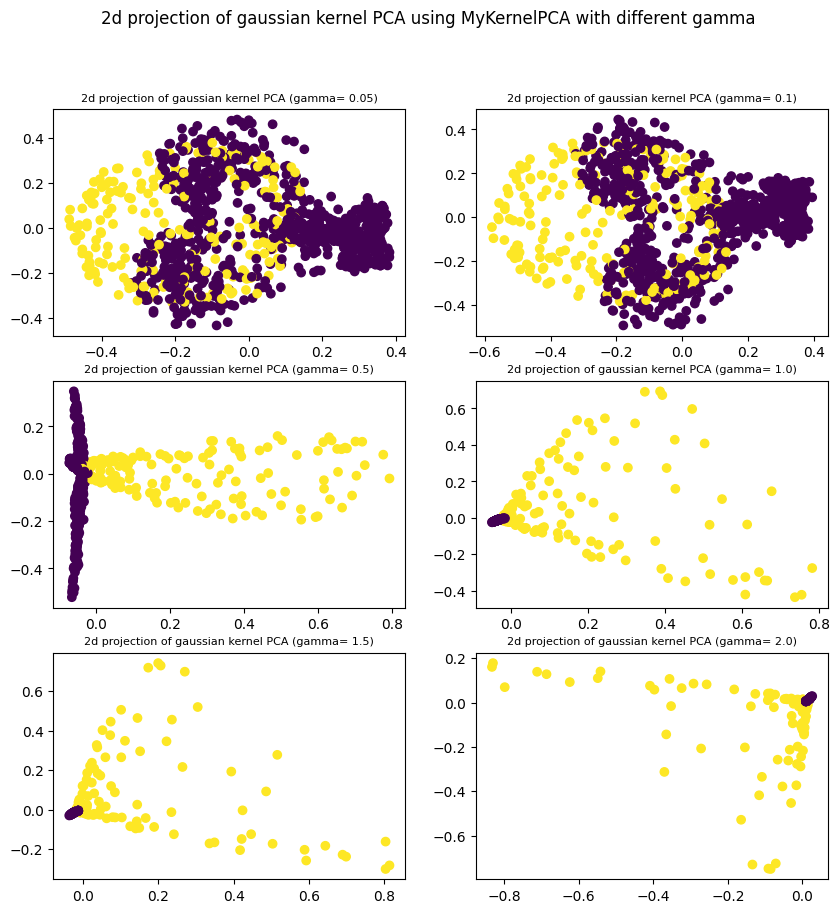

In [10]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize = (10, 10))
axs = axs.flatten()
fig.suptitle('2d projection of gaussian kernel PCA using MyKernelPCA with different gamma')

gammas = np.array([0.05, 0.1, 0.5, 1.0, 1.5, 2.0])

for i in range(len(gammas)):
    Y = MyRBFKernelPCA(2, gamma = gammas[i]).fit_transform(X[:1000,:])

    ax = axs[i]
    ax.scatter(Y[:, 0], Y[:, 1], c = y.ravel()[:1000])
    ax.set_title(f'2d projection of gaussian kernel PCA (gamma= {gammas[i]})', fontdict={'fontsize':8})

plt.show()

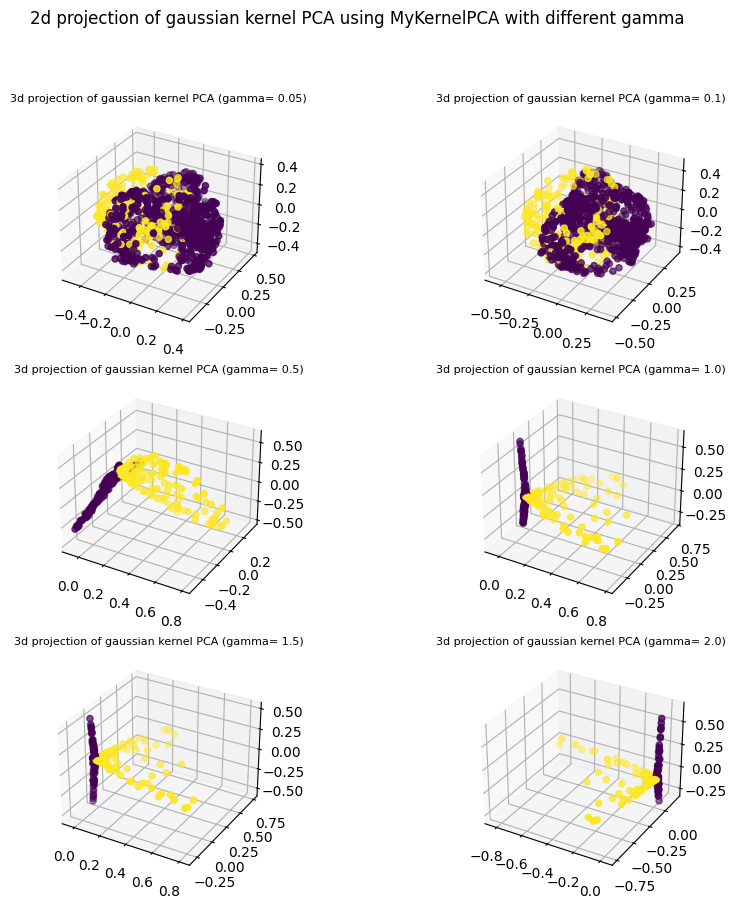

In [11]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize = (10, 10), subplot_kw={'projection': '3d'})
axs = axs.flatten()
fig.suptitle('2d projection of gaussian kernel PCA using MyKernelPCA with different gamma')

gammas = np.array([0.05, 0.1, 0.5, 1.0, 1.5, 2.0])

for i in range(len(gammas)):
    Y = MyRBFKernelPCA(3, gamma = gammas[i]).fit_transform(X[:1000,:])

    ax = axs[i]
    ax.scatter(Y[:, 0], Y[:, 1], Y[:,2], c = y.ravel()[:1000])
    ax.set_title(f'3d projection of gaussian kernel PCA (gamma= {gammas[i]})', fontdict={'fontsize':8})

plt.show()


### Plynomial kernel

In [12]:
def pol(x,y, gamma, d):
    """
    Polynomial kernel function between two feature vectors. 
    ----------
    Parameters:
        x, y (`numpy.ndarray`): feature vectors to compute the kernel between.
        gamma (float): Scaling factor.
        d (int): Degree of the polynomial. 
    Returns:
        float: Kernel function output.
    """
    return (gamma*np.dot(x,y) + 1)**d


class MyPolyKernelPCA:
    """
    Kernel PCA using polynomial kernel function.
    """
    
    def __init__(self, n_components=None, gamma = 1.0, d = 2):
        """
        Constructor method that initializes class variables. 
        ----------
        Parameters:
        n_components: int
            Number of principal components to project on (default is None, meaning to project on all components).
        gamma: float, default = 1.0 
            Scaling factor.
        d: int, default = 2
            Degree of the polynomial. 
        """
        self.n_components = n_components
        self.gamma = gamma
        self.d = d
    
    def fit_transform(self, X):
        """
        Compute the kernel matrix between all observations in X and use it to fit the kernel PCA model onto data X and return the projected data. 
        ----------
        Parameters:
        X: numpy.ndarray
            Data to fit and transform. Required in the form: (n x p) where n = number of observations and p = number of features.
        Returns:
            numpy.ndarray: The projected data. 
        """
        # compute the squared Euclidean distances
        K = np.zeros([X.shape[0], X.shape[0]])
        for i in range(X.shape[0]):
            for j in range(X.shape[0]):
                K[i,j] = pol(X[i], X[j], gamma=self.gamma, d = self.d)

        # double center the kernel matrix
        n = K.shape[0]
        one_n = np.ones((n, n)) / n
        K_centered = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)

        # compute the eigenvalues and eigenvectors of the kernel matrix
        eig_vals, eig_vecs = np.linalg.eig(K_centered)
        eig_vals = np.where(eig_vals<0,0, eig_vals)
        sorted_indices = np.argsort(eig_vals)[::-1]
        sorted_eigvecs = eig_vecs[:,sorted_indices]
        sorted_eigvals = eig_vals[sorted_indices]

        # select the first k eigenvectors and eigenvalues and project
        top_k_eigvecs = sorted_eigvecs[:,:self.n_components]
        top_k_eigvals = sorted_eigvals[:self.n_components]
    
        return np.dot(top_k_eigvecs, np.sqrt(np.diag(top_k_eigvals)))


In [13]:
gamma = 6.0
X_projected_ = KernelPCA(n_components=2, kernel='poly', gamma=gamma, degree=3).fit_transform(X[:500,:])
X_projected = MyPolyKernelPCA(2, gamma = gamma, d = 3).fit_transform(X[:500,:])

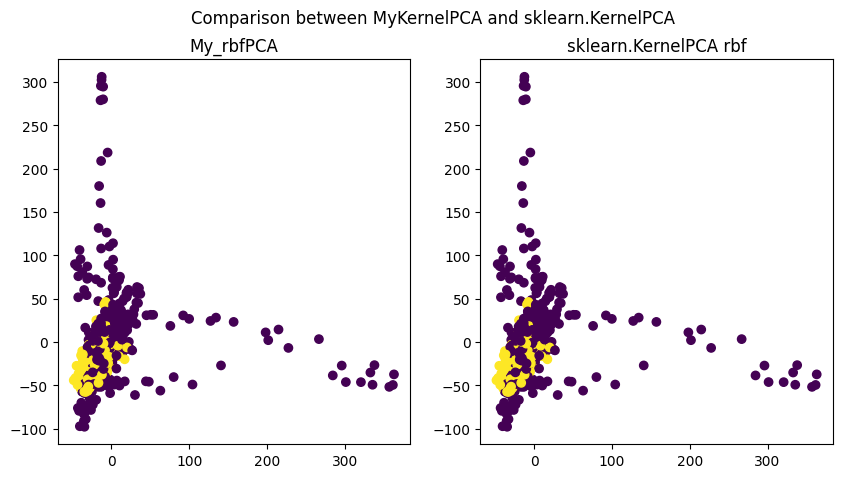

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Comparison between MyKernelPCA and sklearn.KernelPCA')

ax1.scatter(X_projected[:,0], X_projected[:,1], c = y.ravel()[:500])
ax1.set_title('My_rbfPCA')

ax2.scatter(X_projected_[:,0], X_projected_[:,1], c = y.ravel()[:500])
ax2.set_title('sklearn.KernelPCA rbf')

plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/collections.py:193: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


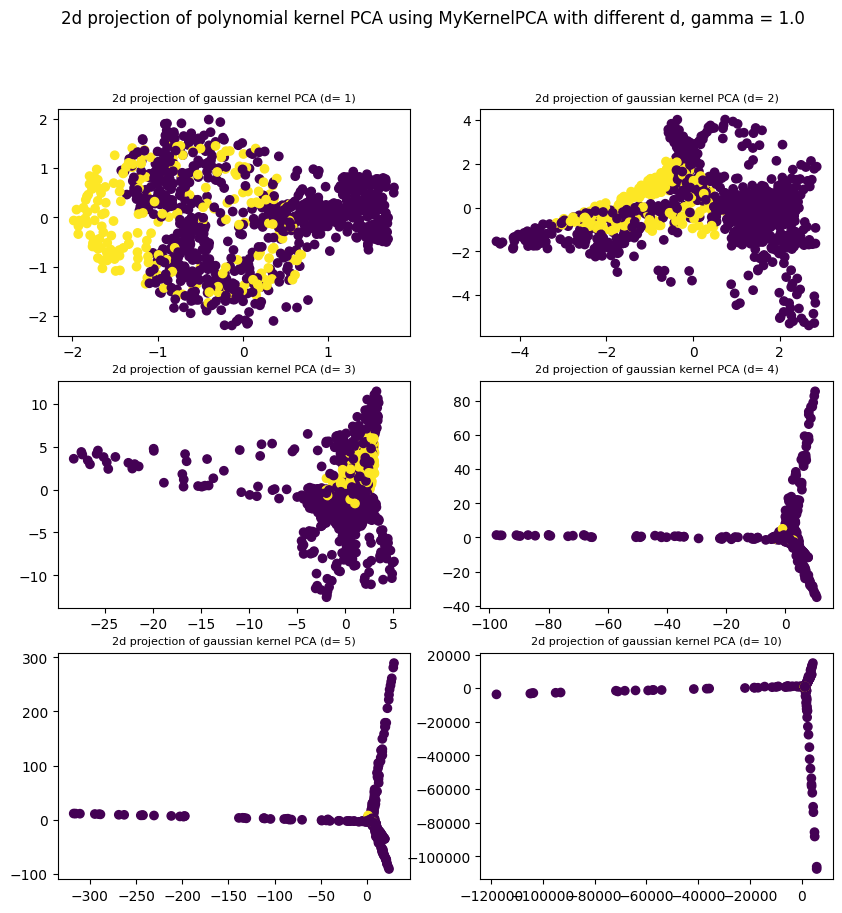

In [15]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize = (10, 10))
axs = axs.flatten()
fig.suptitle('2d projection of polynomial kernel PCA using MyKernelPCA with different d, gamma = 1.0')

deg = np.array([1,2,3,4,5,10])

for i in range(len(deg)):
    Y = MyPolyKernelPCA(2, gamma=1.0, d= deg[i]).fit_transform(X[:1000,:])

    ax = axs[i]
    ax.scatter(Y[:, 0], Y[:, 1], c = y.ravel()[:1000])
    ax.set_title(f'2d projection of gaussian kernel PCA (d= {deg[i]})', fontdict={'fontsize':8})

plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/collections.py:550: ComplexWarning: Casting complex values to real discards the imaginary part
  (np.asarray(self.convert_xunits(offsets[:, 0]), 'float'),
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/collections.py:551: ComplexWarning: Casting complex values to real discards the imaginary part
  np.asarray(self.convert_yunits(offsets[:, 1]), 'float')))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/matplotlib/colors.py:389: ComplexWarning: Casting complex values to real discards the imaginary part
  c = tuple(map(float, c))


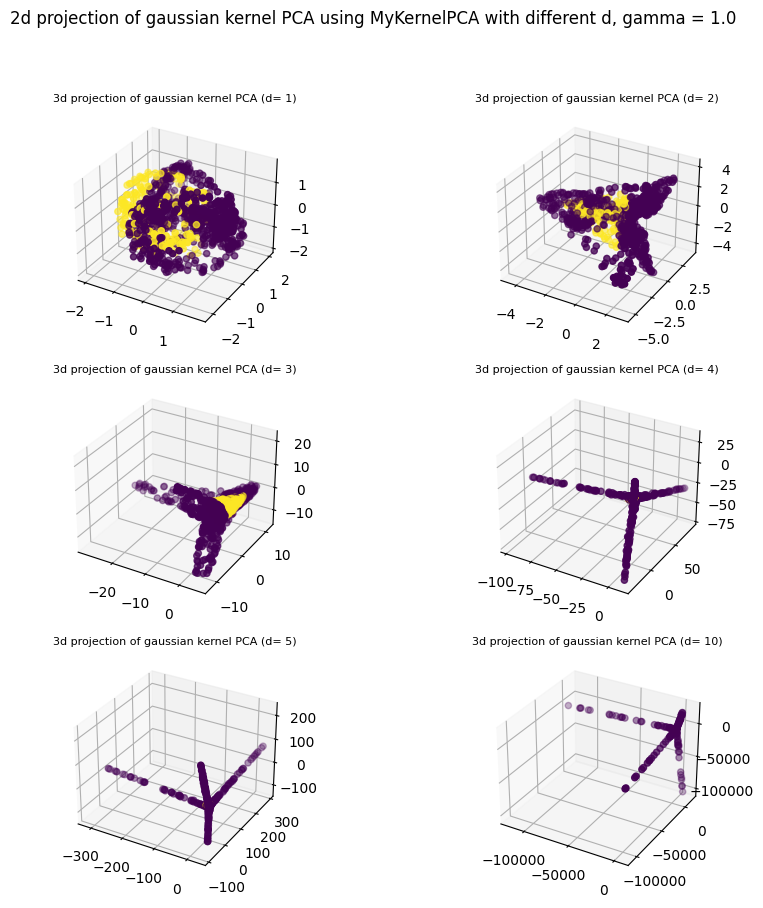

In [16]:
fig, axs = plt.subplots(nrows=3, ncols=2, figsize = (10, 10), subplot_kw={'projection': '3d'})
axs = axs.flatten()
fig.suptitle('2d projection of gaussian kernel PCA using MyKernelPCA with different d, gamma = 1.0')

deg = np.array([1,2,3,4,5,10])

for i in range(len(deg)):
    Y = MyPolyKernelPCA(3, gamma = 1.0, d=deg[i]).fit_transform(X[:1000,:])

    ax = axs[i]
    ax.scatter(Y[:, 0], Y[:, 1], Y[:,2], c = y.ravel()[:1000])
    ax.set_title(f'3d projection of gaussian kernel PCA (d= {deg[i]})', fontdict={'fontsize':8})

plt.show()
